In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# --- 来自 10_2_Rc.ipynb 的相关设置 ---
# 1. 定义微分方程的右侧 f(t, y)
# 在你的 notebook 中，dydt = sp.lambdify((t, v_c), 1.0 - 1.0*V_C(t), modules='numpy')
# V_C(t) 是状态变量，我们这里用 y 表示。t 是时间。
# 所以，dy/dt = 1.0 - 1.0*y
def dydt_rc_circuit(t, y):
    """
    计算RC电路中电容电压的变化率。
    t: 当前时间 (虽然在这个特定方程中未使用，但通用ODE函数通常需要它)
    y: 当前电容电压 V_C(t)
    返回: dV_C(t)/dt
    """
    return 1.0 - 1.0 * y

In [3]:

# 2. 设置积分参数
t_span = (0.0, 10.0)  # (t0, tf) 积分时间区间 (秒)
u0 = [0.0]             # 初始电容电压 V_C(t0) = 0.0 V
# 我们需要自己定义时间步和评估点
num_points = 100       # 希望得到解的时间点数量
t_eval = np.linspace(t_span[0], t_span[1], num_points) # 在这些时间点评估解

In [10]:
t_eval

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [5]:
def forward_euler_solver(func, t_span, y0, t_eval):
    """
    使用前向欧拉法求解常微分方程初值问题。

    参数:
    func : callable
        计算 dy/dt 的函数，签名为 func(t, y)。
    t_span : tuple
        (t_initial, t_final)，积分的起始和结束时间。
    y0 : array_like
        初始条件，y(t_initial)。
    t_eval : array_like
        需要计算并返回解的一系列时间点。这些点必须是已排序的，
        并且位于 t_span 内。

    返回:
    t_sol : numpy.ndarray
        与 t_eval 对应的时间点。
    y_sol : numpy.ndarray
        在 t_sol 的每个时间点上计算得到的解。
        如果 y0 是一个标量或一维数组，则 y_sol 的形状是 (len(t_eval), len(y0))。
    """
    # 解释: 将初始条件转换为 NumPy 数组，确保后续计算的类型一致性。
    y_current = np.asarray(y0, dtype=np.float64)

    # 解释: 获取 t_eval 中的时间点作为我们要计算和存储解的时刻。
    # 并初始化一个列表来存储每个时间点的解。
    solution_times = np.asarray(t_eval, dtype=np.float64)
    solution_y_values = [y_current.copy()] # 存储初始条件

    # 解释: 遍历 t_eval 中的时间点（从第二个开始，因为第一个是初始时间点）。
    # 对于每两个连续的时间点，计算它们之间的时间差 dt (即步长 h)。
    # 然后使用前向欧拉公式更新 y_current。
    for i in range(1, len(solution_times)):
        t_previous = solution_times[i-1] # 上一个时间点
        t_current_eval = solution_times[i]  # 当前评估的时间点

        # 解释: 计算从上一个评估点到当前评估点的时间步长。
        # 在更复杂的自适应步长求解器中，这个 h 会动态变化。
        # 在我们这个简单的实现中，h 由 t_eval 的间距决定。
        h = t_current_eval - t_previous

        # 解释: 这是前向欧拉法的核心步骤。
        # func(t_previous, y_current) 计算在 t_previous 时的导数 dy/dt。
        # 然后 y_current 加上 (步长 * 导数) 来估算下一个时间点的 y 值。
        y_next = y_current + h * func(t_previous, y_current)

        # 解释: 更新 y_current 为新计算的值，为下一次迭代做准备。
        y_current = y_next

        # 解释: 将当前计算得到的解 y_current 添加到存储列表中。
        solution_y_values.append(y_current.copy())

    # 解释: 将存储解的列表转换为一个 NumPy 数组，方便后续处理和绘图。
    # 数组的每一行对应一个时间点，每一列对应一个状态变量（在RC电路中只有一个）。
    return solution_times, np.array(solution_y_values)

In [6]:
# --- 前向欧拉法实现 ---


# --- 使用我们实现的求解器 ---
# 解释: 调用我们自己写的 forward_euler_solver 函数。
# 参数分别是:
#   dydt_rc_circuit: 我们定义的微分方程函数。
#   t_span: 积分区间 (虽然在我们的简单求解器中，它主要通过 t_eval 来间接使用)。
#   u0: 初始电压。
#   t_eval: 我们希望得到解的时间点。
t_solved_euler, y_solved_euler = forward_euler_solver(dydt_rc_circuit, t_span, u0, t_eval)

In [7]:
# --- 为了比较，我们也用 scipy.integrate.solve_ivp 求解 ---
from scipy.integrate import solve_ivp
sol_scipy = solve_ivp(dydt_rc_circuit, t_span, u0, t_eval=t_eval)

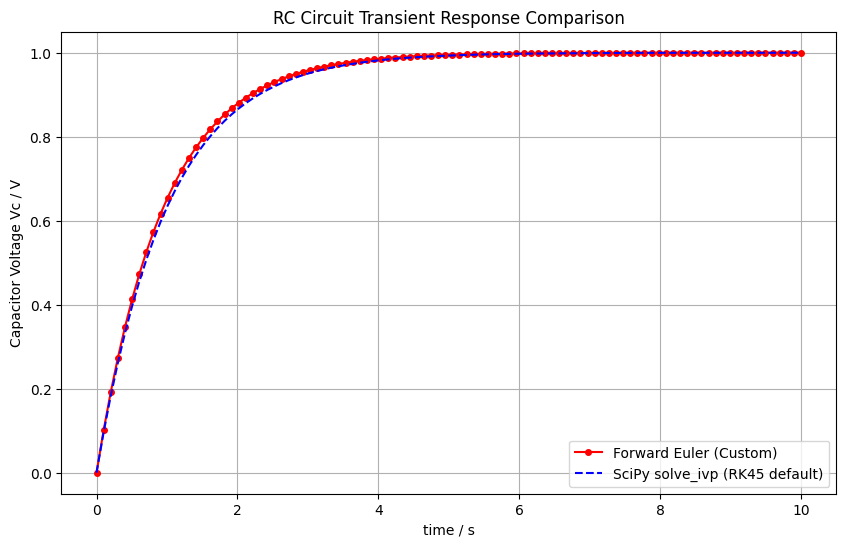

---- Euler Method Results ----
Time: 0.00 s, Voltage (Euler): 0.0000 V
Time: 0.10 s, Voltage (Euler): 0.1010 V
Time: 0.20 s, Voltage (Euler): 0.1918 V
Time: 0.30 s, Voltage (Euler): 0.2735 V
Time: 0.40 s, Voltage (Euler): 0.3468 V

---- SciPy solve_ivp Results ----
Time: 0.00 s, Voltage (SciPy): 0.0000 V
Time: 0.10 s, Voltage (SciPy): 0.0961 V
Time: 0.20 s, Voltage (SciPy): 0.1829 V
Time: 0.30 s, Voltage (SciPy): 0.2615 V
Time: 0.40 s, Voltage (SciPy): 0.3324 V


In [8]:

# --- 可视化结果 ---
plt.figure(figsize=(10, 6))
# 解释: 绘制我们自己实现的欧拉法求解器的结果。
# t_solved_euler 是一系列时间点。
# y_solved_euler[:, 0] 是这些时间点对应的电容电压 (因为u0是[0.0]，所以y_solved_euler会有两维)。
plt.plot(t_solved_euler, y_solved_euler[:, 0], 'r-o', label='Forward Euler (Custom)', markersize=4)

# 解释: 绘制 SciPy 的 solve_ivp 的结果作为参考。
# sol_scipy.t 是时间点。
# sol_scipy.y[0] 是对应的电容电压 (solve_ivp 返回的y是 (n_states, n_times) 的形状)。
plt.plot(sol_scipy.t, sol_scipy.y[0], 'b--', label='SciPy solve_ivp (RK45 default)')

plt.xlabel("time / s")
plt.ylabel("Capacitor Voltage Vc / V")
plt.title("RC Circuit Transient Response Comparison")
plt.grid(True)
plt.legend()
plt.show()

print("---- Euler Method Results ----")
# 解释: 打印欧拉法求解结果的前几个时间点和对应的电压值。
for i in range(min(5, len(t_solved_euler))):
    print(f"Time: {t_solved_euler[i]:.2f} s, Voltage (Euler): {y_solved_euler[i, 0]:.4f} V")

print("\n---- SciPy solve_ivp Results ----")
# 解释: 打印 SciPy 求解结果的前几个时间点和对应的电压值。
for i in range(min(5, len(sol_scipy.t))):
    print(f"Time: {sol_scipy.t[i]:.2f} s, Voltage (SciPy): {sol_scipy.y[0, i]:.4f} V")
